# HOG를 이용한 특성 추출
- [참고](https://www.thepythoncode.com/article/hog-feature-extraction-in-python)

In [1]:
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm.notebook import tqdm

(2020, 2020, 3)


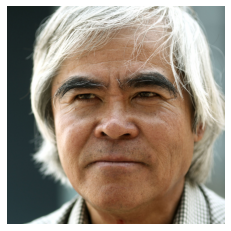

In [2]:
img = imread('../data/telemoji/train/angry/94d0319548dd602f76ccb54cf3c37644f7faeac8d276f6703d8b9ae2.jpg')
plt.axis("off")
plt.imshow(img)
print(img.shape)

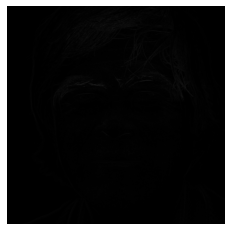

In [6]:
#creating hog features
fd, hog_image = hog(img, orientations=9, pixels_per_cell=(4, 4),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
plt.axis("off")
plt.imshow(hog_image, cmap="gray")

In [ ]:
# save the images
plt.imsave("hog_image.jpg", hog_image, cmap="gray")

In [ ]:
# train 폴더 변환
path_dir = '../data/telemoji/train'
file_list = os.listdir(path_dir)

for fname in file_list:
    # train 폴더 안의 폴더 경로
    temp_dir = os.path.join(path_dir, fname)
    for iname in tqdm(os.listdir(temp_dir),total=len(os.listdir(temp_dir)),position=0,leave=True):
        img = imread(os.path.join(temp_dir, iname))
        fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
        # 저장되는 파일 포맷을 jpg로 지정
        # 중간에 TIF파일이 있는데 이거 때문에 오류나서 포맷을 지정함
        plt.imsave(f"../data/telemoji/HOG/{fname}/{iname.split('.')[0]}.jpg", 
                   hog_image, cmap="gray")

In [ ]:
# validation 폴더 변환
path_dir = '../data/telemoji/validation/'
file_list = os.listdir(path_dir)

for fname in file_list:
    # train 폴더 안의 폴더 경로
    temp_dir = os.path.join(path_dir, fname)
    for iname in tqdm(os.listdir(temp_dir),total=len(os.listdir(temp_dir)),position=0,leave=True):
        img = imread(os.path.join(temp_dir, iname))
        fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
        # 저장되는 파일 포맷을 jpg로 지정
        # 중간에 TIF파일이 있는데 이거 때문에 오류나서 포맷을 지정함
        plt.imsave(f"../data/telemoji/HOG/validation/{fname}/{iname.split('.')[0]}.jpg", 
                   hog_image, cmap="gray")

# HOG를 이용한 학습

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications import EfficientNetB3, ResNet50

In [ ]:
base_dir = '../data/telemoji/HOG'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_datagen = ImageDataGenerator(
#       rescale=1/255,    
#     rotation_range=40,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True
)

validation_datagen = ImageDataGenerator(
#     rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    color_mode='grayscale',
    target_size=(112,112),
    batch_size=20,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    color_mode='grayscale',
    target_size=(112,112),
    batch_size=20,
    class_mode='categorical'
)

In [ ]:
## 다른 모델

model = Sequential()
model.add(Conv2D(64, (1, 1), padding='same', activation='relu', 
                 input_shape=(112, 112, 1)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(256, (5, 5),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2),padding="same"))
model.add(Dropout(0.25))


model.add(Flatten())

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(optimizer=Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, steps_per_epoch=840, epochs=30,
                    validation_data=validation_generator,
                    validation_steps=350)